
# Análise Estatística: Acidentes com Feridos Graves – Veículos Elétricos vs. Frota Geral

## 1. Contexto e Hipótese Principal
**Objetivo geral**: Comparar a probabilidade de acidentes com feridos graves entre veículos elétricos (EV) e não elétricos (frota geral), controlando por fatores temporais e geográficos.


**Hipóteses estatísticas**:
- **H₀**: A proporção de acidentes com feridos graves envolvendo EV é igual à da frota geral (após ajustes). Formal: \( p_{EV} = p_{geral} \) ou no modelo \( \beta_{EV} = 0 \).
- **H₁**: As proporções são diferentes: \( p_{EV} \neq p_{geral} \) (alternativa bilateral). (Inclui também as alternativas unilaterais possíveis: \( p_{EV} > p_{geral} \) e \( p_{EV} < p_{geral} \) quando pertinente).

## 2. Imports e Configurações Iniciais

In [52]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Estatística
from scipy import stats
from scipy.stats import (shapiro, norm, binom, poisson, hypergeom, nbinom, t,
                         ttest_ind, f, f_oneway, chi2_contingency,
                         bartlett, levene, fligner, chisquare, kruskal,
                         probplot, skew, kurtosis, sem)


# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

np.random.seed(42)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 3. Carregamento e Limpeza dos Dados

In [53]:
# Carregar os datasets
collisions_path = "../archives/Motor_Vehicle_Collisions_-_Crashes.csv"
ev_population_path = "../archives/Electric_Vehicle_Population_Data.csv"


collisions = pd.read_csv(collisions_path, low_memory=False)
ev_population = pd.read_csv(ev_population_path, low_memory=False)


print(f"Dataset de colisões: {collisions.shape}")
print(f"Dataset de veículos elétricos: {ev_population.shape}")


Dataset de colisões: (2223272, 29)
Dataset de veículos elétricos: (269673, 17)


### 3.1 Limpeza Básica

In [54]:
# Padronizar nomes de colunas
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('[^a-zA-Z0-9_]', '', regex=True)
    )
    return df

collisions = clean_columns(collisions)
ev_population = clean_columns(ev_population)

# Tratar datas
if 'crash_date' in collisions.columns:
    collisions['crash_date'] = pd.to_datetime(collisions['crash_date'], errors='coerce')
    collisions['crash_year'] = collisions['crash_date'].dt.year

# Criar variável de desfecho: ferido_grave
collisions['n_persons_injured'] = pd.to_numeric(
    collisions.get('number_of_persons_injured', 0),
    errors='coerce'
).fillna(0)

collisions['n_persons_killed'] = pd.to_numeric(
    collisions.get('number_of_persons_killed', 0),
    errors='coerce'
).fillna(0)

collisions['ferido_grave'] = ((collisions['n_persons_injured'] > 0) |
                              (collisions['n_persons_killed'] > 0)).astype(int)

# Criar variável de exposição: is_EV
vehicle_cols = [col for col in collisions.columns if 'vehicle_type' in col]
ev_keywords = ['electric', 'ev', 'hybrid', 'plug-in', 'battery']

def detect_ev(text):
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return 1 if any(keyword in text_lower for keyword in ev_keywords) else 0

if vehicle_cols:
    ev_flags = []
    for col in vehicle_cols[:2]:  # Usar apenas as primeiras 2 colunas
        ev_flags.append(collisions[col].apply(detect_ev))
   
    ev_matrix = pd.concat(ev_flags, axis=1)
    collisions['is_EV'] = ev_matrix.any(axis=1).astype(int)
else:
    collisions['is_EV'] = 0

# Filtrar dados relevantes
analysis_cols = ['ferido_grave', 'is_EV', 'crash_year', 'n_persons_injured']
analysis_cols = [col for col in analysis_cols if col in collisions.columns]

df = collisions[analysis_cols].dropna().copy()
print(f"\nDataset para análise: {df.shape}")
print(f"Proporção de EV: {df['is_EV'].mean():.4f}")
print(f"Proporção de feridos graves: {df['ferido_grave'].mean():.4f}")


Dataset para análise: (2223272, 4)
Proporção de EV: 0.0003
Proporção de feridos graves: 0.2437


## 4. Estatística Descritiva


### 4.1 Medidas de Tendência Central e Dispersão


In [55]:
print("=== ESTATÍSTICA DESCRITIVA ===")
print("\n1. MEDIDAS DE TENDÊNCIA CENTRAL E DISPERSÃO")


# Separar por grupo
df_EV = df[df['is_EV'] == 1]
df_nao_EV = df[df['is_EV'] == 0]


# Para variável numérica: número de feridos
if 'n_persons_injured' in df.columns:
    print("\nNúmero de Feridos por Acidente:")
   
    for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV), ('Total', df)]:
        if len(grupo) > 0:
            dados = grupo['n_persons_injured']
            print(f"\n{nome} (n={len(grupo)}):")
            print(f"  Média: {dados.mean():.4f}")
            print(f"  Mediana: {dados.median():.4f}")
            print(f"  Moda: {dados.mode().values[0] if len(dados.mode()) > 0 else 'N/A'}")
            print(f"  Variância: {dados.var():.4f}")
            print(f"  Desvio-padrão: {dados.std():.4f}")
            print(f"  Erro-padrão: {sem(dados):.4f}")
            print(f"  Mínimo: {dados.min():.0f}")
            print(f"  Máximo: {dados.max():.0f}")
            print(f"  Q1: {dados.quantile(0.25):.4f}")
            print(f"  Q3: {dados.quantile(0.75):.4f}")
            print(f"  IQR: {dados.quantile(0.75) - dados.quantile(0.25):.4f}")
            print(f"  Assimetria (skewness): {skew(dados):.4f}")
            print(f"  Curtose (kurtosis): {kurtosis(dados):.4f}")


=== ESTATÍSTICA DESCRITIVA ===

1. MEDIDAS DE TENDÊNCIA CENTRAL E DISPERSÃO

Número de Feridos por Acidente:

EV (n=724):
  Média: 0.2624
  Mediana: 0.0000
  Moda: 0.0
  Variância: 0.3404
  Desvio-padrão: 0.5835
  Erro-padrão: 0.0217
  Mínimo: 0
  Máximo: 4
  Q1: 0.0000
  Q3: 0.0000
  IQR: 0.0000
  Assimetria (skewness): 2.7672
  Curtose (kurtosis): 9.3564

Não-EV (n=2222548):
  Média: 0.3286
  Mediana: 0.0000
  Moda: 0.0
  Variância: 0.5114
  Desvio-padrão: 0.7151
  Erro-padrão: 0.0005
  Mínimo: 0
  Máximo: 43
  Q1: 0.0000
  Q3: 0.0000
  IQR: 0.0000
  Assimetria (skewness): 4.0849
  Curtose (kurtosis): 46.6695

Total (n=2223272):
  Média: 0.3285
  Mediana: 0.0000
  Moda: 0.0
  Variância: 0.5113
  Desvio-padrão: 0.7151
  Erro-padrão: 0.0005
  Mínimo: 0
  Máximo: 43
  Q1: 0.0000
  Q3: 0.0000
  IQR: 0.0000
  Assimetria (skewness): 4.0848
  Curtose (kurtosis): 46.6660


### 4.2 Visualizações Descritivas


2. VISUALIZAÇÕES DESCRITIVAS


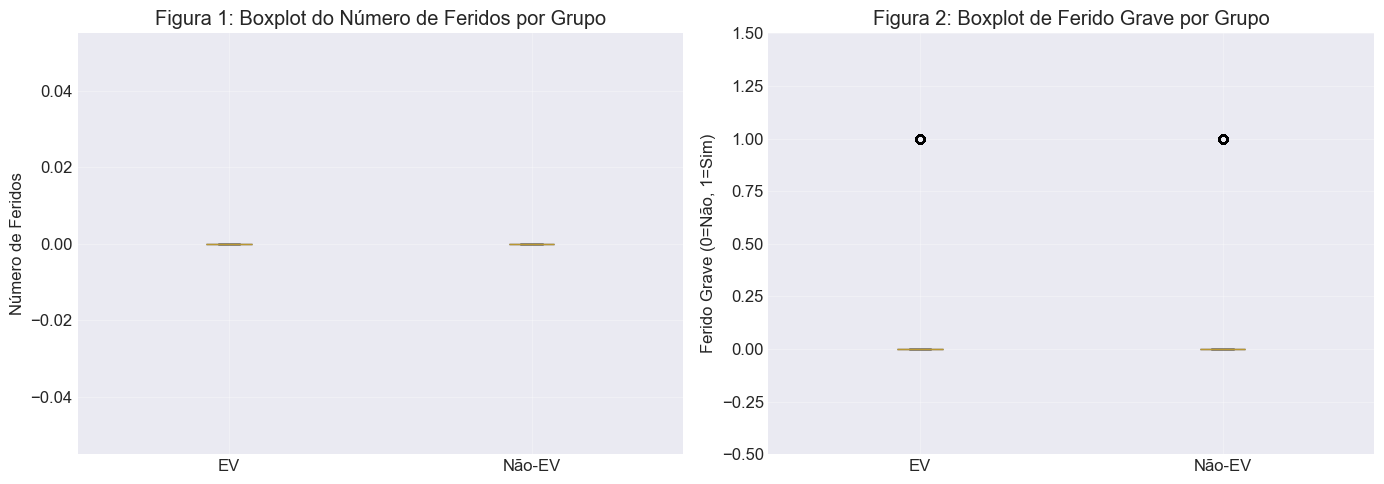

In [56]:
print("\n2. VISUALIZAÇÕES DESCRITIVAS")


# Figura 1: Boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Boxplot do número de feridos
if 'n_persons_injured' in df.columns:
    ax1 = axes[0]
    data_to_plot = []
    labels = []
   
    for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV)]:
        if len(grupo) > 0:
            # Filtrar outliers extremos para melhor visualização
            dados = grupo['n_persons_injured']
            Q1 = dados.quantile(0.25)
            Q3 = dados.quantile(0.75)
            IQR = Q3 - Q1
            dados_filtrados = dados[(dados >= Q1 - 1.5*IQR) & (dados <= Q3 + 1.5*IQR)]
           
            if len(dados_filtrados) > 0:
                data_to_plot.append(dados_filtrados)
                labels.append(nome)
   
    if data_to_plot:
        bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
        colors = ['lightcoral', 'skyblue']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax1.set_ylabel('Número de Feridos')
        ax1.set_title('Figura 1: Boxplot do Número de Feridos por Grupo')
        ax1.grid(True, alpha=0.3)


# Boxplot da variável binária (ferido_grave)
ax2 = axes[1]
data_to_plot = []
labels = []


for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV)]:
    if len(grupo) > 0:
        data_to_plot.append(grupo['ferido_grave'])
        labels.append(nome)


if data_to_plot:
    bp2 = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
    colors = ['lightcoral', 'skyblue']
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_ylabel('Ferido Grave (0=Não, 1=Sim)')
    ax2.set_title('Figura 2: Boxplot de Ferido Grave por Grupo')
    ax2.set_ylim(-0.5, 1.5)
    ax2.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


### 4.3 Histogramas e Distribuições

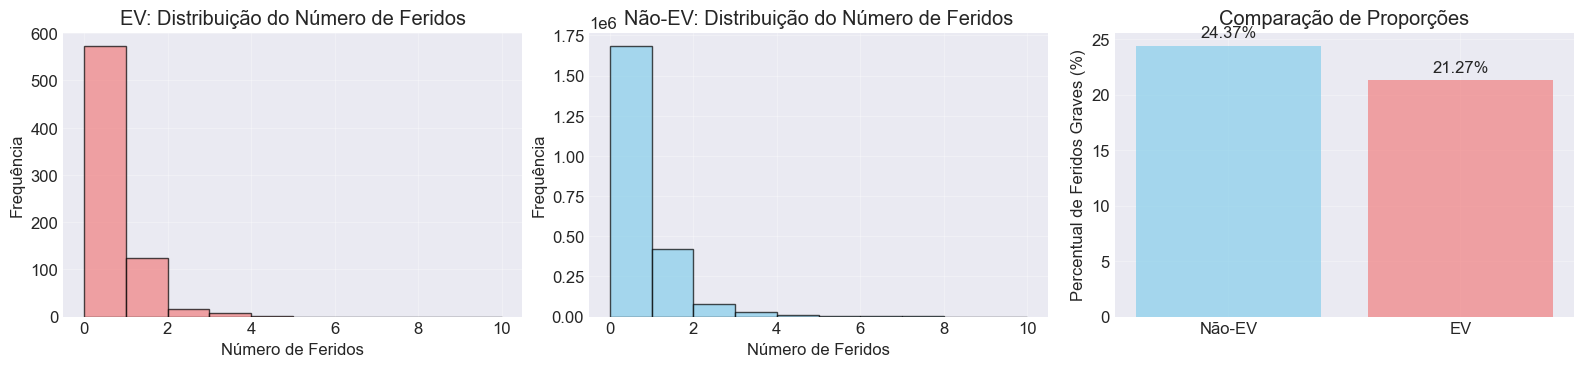

In [57]:
# Figura 2: Histogramas
fig, axes = plt.subplots(1, 3, figsize=(16, 4))


# Histograma do número de feridos (EV)
if 'n_persons_injured' in df.columns and len(df_EV) > 0:
    ax1 = axes[0]
    ax1.hist(df_EV['n_persons_injured'], bins=range(0, 11),
             edgecolor='black', alpha=0.7, color='lightcoral')
    ax1.set_xlabel('Número de Feridos')
    ax1.set_ylabel('Frequência')
    ax1.set_title('EV: Distribuição do Número de Feridos')
    ax1.grid(True, alpha=0.3)


# Histograma do número de feridos (Não-EV)
if 'n_persons_injured' in df.columns and len(df_nao_EV) > 0:
    ax2 = axes[1]
    ax2.hist(df_nao_EV['n_persons_injured'], bins=range(0, 11),
             edgecolor='black', alpha=0.7, color='skyblue')
    ax2.set_xlabel('Número de Feridos')
    ax2.set_ylabel('Frequência')
    ax2.set_title('Não-EV: Distribuição do Número de Feridos')
    ax2.grid(True, alpha=0.3)


# Histograma comparativo de ferido_grave
ax3 = axes[2]
if len(df) > 0:
    proporcoes = df.groupby('is_EV')['ferido_grave'].mean()
    bars = ax3.bar(['Não-EV', 'EV'], proporcoes.values * 100,
                   color=['skyblue', 'lightcoral'], alpha=0.7)
    ax3.set_ylabel('Percentual de Feridos Graves (%)')
    ax3.set_title('Comparação de Proporções')
    ax3.grid(True, alpha=0.3)
   
    # Adicionar valores nas barras
    for bar, valor in zip(bars, proporcoes.values * 100):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{valor:.2f}%', ha='center', va='bottom')


plt.tight_layout()
plt.show()

### 4.4 Testes de Normalidade


3. TESTES DE NORMALIDADE

Teste de Shapiro-Wilk para normalidade:

EV (n=724):
  Estatística W: 0.5000
  Valor-p: 0.000000
  Conclusão: Rejeita normalidade (p < 0.05)

Não-EV (n=2222548):
  Estatística W: 0.5041
  Valor-p: 0.000000
  Conclusão: Rejeita normalidade (p < 0.05)


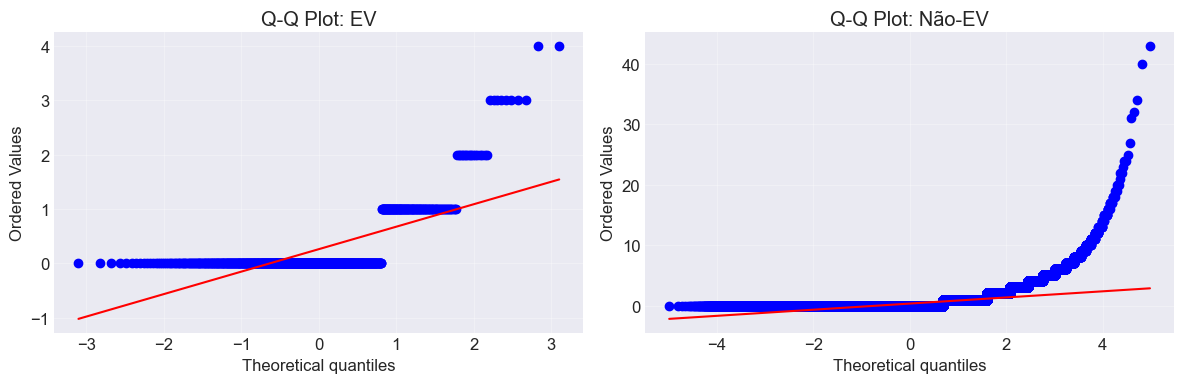

In [58]:
print("\n3. TESTES DE NORMALIDADE")


# Testar normalidade do número de feridos
if 'n_persons_injured' in df.columns:
    print("\nTeste de Shapiro-Wilk para normalidade:")
   
    for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV)]:
        if len(grupo) > 3:  # Shapiro-Wilk requer pelo menos 3 observações
            dados = grupo['n_persons_injured']
            stat, p = shapiro(dados)
            print(f"\n{nome} (n={len(grupo)}):")
            print(f"  Estatística W: {stat:.4f}")
            print(f"  Valor-p: {p:.6f}")
           
            if p < 0.05:
                print("  Conclusão: Rejeita normalidade (p < 0.05)")
            else:
                print("  Conclusão: Não rejeita normalidade (p ≥ 0.05)")
   
    # Q-Q plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
   
    if len(df_EV) > 0:
        ax1 = axes[0]
        probplot(df_EV['n_persons_injured'], dist="norm", plot=ax1)
        ax1.set_title('Q-Q Plot: EV')
        ax1.grid(True, alpha=0.3)
   
    if len(df_nao_EV) > 0:
        ax2 = axes[1]
        probplot(df_nao_EV['n_persons_injured'], dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot: Não-EV')
        ax2.grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()


### 4.5 Testes de Homogeneidade de Variâncias

In [59]:
print("\n4. TESTES DE HOMOGENEIDADE DE VARIÂNCIAS")

if 'n_persons_injured' in df.columns and len(df_EV) > 1 and len(df_nao_EV) > 1:
    dados_EV = df_EV['n_persons_injured']
    dados_nao_EV = df_nao_EV['n_persons_injured']
   
    print("\nComparando variâncias entre EV e Não-EV:")
    print(f"Variância EV: {dados_EV.var():.4f}")
    print(f"Variância Não-EV: {dados_nao_EV.var():.4f}")
    print(f"Razão F: {dados_EV.var()/dados_nao_EV.var():.4f}")
   
    # Teste F (assume normalidade)
    print("\nTeste F para igualdade de variâncias:")
    F = dados_EV.var() / dados_nao_EV.var()
    df1 = len(dados_EV) - 1
    df2 = len(dados_nao_EV) - 1
    p_F = 2 * min(f.cdf(F, df1, df2), 1 - f.cdf(F, df1, df2))
    print(f"  Estatística F: {F:.4f}")
    print(f"  Valor-p: {p_F:.6f}")
   
    # Teste de Bartlett (assume normalidade)
    print("\nTeste de Bartlett:")
    stat_b, p_b = bartlett(dados_EV, dados_nao_EV)
    print(f"  Estatística: {stat_b:.4f}")
    print(f"  Valor-p: {p_b:.6f}")
   
    # Teste de Levene (menos sensível a não-normalidade)
    print("\nTeste de Levene:")
    stat_l, p_l = levene(dados_EV, dados_nao_EV)
    print(f"  Estatística: {stat_l:.4f}")
    print(f"  Valor-p: {p_l:.6f}")
   
    # Teste de Fligner-Killeen (robusto a não-normalidade)
    print("\nTeste de Fligner-Killeen:")
    stat_fk, p_fk = fligner(dados_EV, dados_nao_EV)
    print(f"  Estatística: {stat_fk:.4f}")
    print(f"  Valor-p: {p_fk:.6f}")
   
    # Interpretação
    print("\nInterpretação:")
    if p_b < 0.05 or p_l < 0.05 or p_fk < 0.05:
        print("  Rejeita H₀: Variâncias são diferentes entre grupos (p < 0.05)")
    else:
        print("  Não rejeita H₀: Variâncias são homogêneas entre grupos (p ≥ 0.05)")



4. TESTES DE HOMOGENEIDADE DE VARIÂNCIAS

Comparando variâncias entre EV e Não-EV:
Variância EV: 0.3404
Variância Não-EV: 0.5114
Razão F: 0.6657

Teste F para igualdade de variâncias:
  Estatística F: 0.6657
  Valor-p: 0.000000

Teste de Bartlett:
  Estatística: 52.4607
  Valor-p: 0.000000

Teste de Levene:
  Estatística: 6.1890
  Valor-p: 0.012854

Teste de Fligner-Killeen:
  Estatística: 6.0441
  Valor-p: 0.013953

Interpretação:
  Rejeita H₀: Variâncias são diferentes entre grupos (p < 0.05)


## 5. Probabilidade

### 5.1 Probabilidades Condicionais

In [60]:
print("=== PROBABILIDADE ===")
print("\n1. PROBABILIDADES CONDICIONAIS")


# Calcular probabilidades básicas
p_ferido = df['ferido_grave'].mean()
p_EV = df['is_EV'].mean()
p_ferido_EV = df[df['is_EV'] == 1]['ferido_grave'].mean()
p_ferido_naoEV = df[df['is_EV'] == 0]['ferido_grave'].mean()


print(f"P(Ferido Grave) = {p_ferido:.4f}")
print(f"P(EV) = {p_EV:.4f}")
print(f"P(Ferido Grave | EV) = {p_ferido_EV:.4f}")
print(f"P(Ferido Grave | Não-EV) = {p_ferido_naoEV:.4f}")


# Teorema de Bayes
print("\nAplicando Teorema de Bayes:")
print(f"P(EV | Ferido Grave) = [P(Ferido Grave | EV) * P(EV)] / P(Ferido Grave)")


p_EV_ferido = (p_ferido_EV * p_EV) / p_ferido if p_ferido > 0 else 0
print(f"P(EV | Ferido Grave) = ({p_ferido_EV:.4f} * {p_EV:.4f}) / {p_ferido:.4f} = {p_EV_ferido:.4f}")


print(f"\nInterpretação:")
print(f"  • Probabilidade de ser EV dado que houve ferido grave: {p_EV_ferido*100:.2f}%")
print(f"  • Probabilidade a priori de ser EV: {p_EV*100:.2f}%")
print(f"  • Razão: {p_EV_ferido/p_EV:.2f}x (aumento/diminuição)")




=== PROBABILIDADE ===

1. PROBABILIDADES CONDICIONAIS
P(Ferido Grave) = 0.2437
P(EV) = 0.0003
P(Ferido Grave | EV) = 0.2127
P(Ferido Grave | Não-EV) = 0.2437

Aplicando Teorema de Bayes:
P(EV | Ferido Grave) = [P(Ferido Grave | EV) * P(EV)] / P(Ferido Grave)
P(EV | Ferido Grave) = (0.2127 * 0.0003) / 0.2437 = 0.0003

Interpretação:
  • Probabilidade de ser EV dado que houve ferido grave: 0.03%
  • Probabilidade a priori de ser EV: 0.03%
  • Razão: 0.87x (aumento/diminuição)


### 5.2 Variáveis Aleatórias e Distribuições

In [61]:
print("\n2. VARIÁVEIS ALEATÓRIAS E DISTRIBUIÇÕES")


# Definir variáveis aleatórias
print("\nVariáveis aleatórias definidas:")
print("  • X = Número de feridos por acidente (discreta)")
print("  • Y = Indicador de ferido grave (0/1) (Bernoulli)")
print("  • Z = Indicador de EV (0/1) (Bernoulli)")


# Funções de probabilidade/massa
if 'n_persons_injured' in df.columns and len(df) > 0:
    print("\nFunção de Massa de Probabilidade (FMP) para X (número de feridos):")
   
    # Calcular FMP empírica
    valores_x = df['n_persons_injured'].value_counts().sort_index()
    fmp_empirica = valores_x / len(df)
   
    print(f"Valores possíveis: {list(valores_x.index[:10])}{'...' if len(valores_x) > 10 else ''}")
    print(f"FMP empírica (primeiros 10 valores):")
    for i, (valor, prob) in enumerate(fmp_empirica.items()):
        if i < 10:
            print(f"  P(X = {valor}) = {prob:.6f}")
   
    # FDA empírica
    print(f"\nFunção de Distribuição Acumulada (FDA) empírica:")
    fda_empirica = fmp_empirica.cumsum()
    for i, (valor, prob) in enumerate(fda_empirica.items()):
        if i < 10:
            print(f"  F({valor}) = P(X ≤ {valor}) = {prob:.6f}")



2. VARIÁVEIS ALEATÓRIAS E DISTRIBUIÇÕES

Variáveis aleatórias definidas:
  • X = Número de feridos por acidente (discreta)
  • Y = Indicador de ferido grave (0/1) (Bernoulli)
  • Z = Indicador de EV (0/1) (Bernoulli)

Função de Massa de Probabilidade (FMP) para X (número de feridos):
Valores possíveis: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]...
FMP empírica (primeiros 10 valores):
  P(X = 0.0) = 0.757432
  P(X = 1.0) = 0.188401
  P(X = 2.0) = 0.035376
  P(X = 3.0) = 0.011608
  P(X = 4.0) = 0.004260
  P(X = 5.0) = 0.001643
  P(X = 6.0) = 0.000677
  P(X = 7.0) = 0.000283
  P(X = 8.0) = 0.000126
  P(X = 9.0) = 0.000064

Função de Distribuição Acumulada (FDA) empírica:
  F(0.0) = P(X ≤ 0.0) = 0.757432
  F(1.0) = P(X ≤ 1.0) = 0.945833
  F(2.0) = P(X ≤ 2.0) = 0.981209
  F(3.0) = P(X ≤ 3.0) = 0.992817
  F(4.0) = P(X ≤ 4.0) = 0.997077
  F(5.0) = P(X ≤ 5.0) = 0.998720
  F(6.0) = P(X ≤ 6.0) = 0.999397
  F(7.0) = P(X ≤ 7.0) = 0.999680
  F(8.0) = P(X ≤ 8.0) = 0.999806
  F(9.0) = P(X ≤ 

### 5.3 Ajuste de Distribuições Teóricas

In [62]:
print("\n3. AJUSTE DE DISTRIBUIÇÕES TEÓRICAS")


if 'n_persons_injured' in df.columns and len(df) > 0:
    dados = df['n_persons_injured']
   
    print(f"\nParâmetros dos dados:")
    print(f"  Média: {dados.mean():.4f}")
    print(f"  Variância: {dados.var():.4f}")
   
    # Ajustar distribuição Poisson
    print("\nDistribuição Poisson (adequada para contagens):")
    lambda_poisson = dados.mean()
    print(f"  Parâmetro λ (média) = {lambda_poisson:.4f}")
   
    # Comparar com dados reais
    print("\nComparação Poisson vs Empírica (primeiros 5 valores):")
    for k in range(0, 6):
        p_teorico = poisson.pmf(k, lambda_poisson)
        p_empirico = (dados == k).mean()
        print(f"  P(X={k}): Poisson={p_teorico:.6f}, Empírico={p_empirico:.6f}, Dif={abs(p_teorico-p_empirico):.6f}")
   
    # Ajustar distribuição Binomial Negativa (se overdispersion)
    print(f"\nRazão variância/média: {dados.var()/dados.mean():.4f}")
    if dados.var() > dados.mean():  # Overdispersion
        print("  Overdispersion detectada → Binomial Negativa pode ser mais adequada")
       
        # Estimar parâmetros da Binomial Negativa
        p_nbinom = dados.mean() / dados.var()
        n_nbinom = dados.mean() * p_nbinom / (1 - p_nbinom)
       
        print(f"  Parâmetros Binomial Negativa: n={n_nbinom:.4f}, p={p_nbinom:.4f}")
   
    # Ajustar distribuição Normal (apenas para ilustração)
    print("\nDistribuição Normal (aproximação para grandes amostras):")
    print(f"  μ = {dados.mean():.4f}, σ = {dados.std():.4f}")
   
    # Padronização Z
    print("\nPadronização Z (escore-z):")
    exemplo_valores = [0, 1, 2, 5, 10]
    for x in exemplo_valores:
        if x <= dados.max():
            z = (x - dados.mean()) / dados.std()
            print(f"  Para X={x}: Z = ({x} - {dados.mean():.4f}) / {dados.std():.4f} = {z:.4f}")
   
    # Teste de adequação (qui-quadrado)
    print("\nTeste de adequação (qui-quadrado) para Poisson:")
   
    # Agrupar categorias com frequência esperada < 5
    valores_obs = dados.value_counts().sort_index()
    valores_unicos = valores_obs.index
   
    # Calcular frequências esperadas sob Poisson
    freq_esp = [len(df) * poisson.pmf(k, lambda_poisson) for k in valores_unicos]
   
    # Agrupar categorias
    obs_agrupado = []
    esp_agrupado = []
    temp_obs = 0
    temp_esp = 0
   
    for obs, esp, k in zip(valores_obs.values, freq_esp, valores_unicos):
        temp_obs += obs
        temp_esp += esp
       
        if temp_esp >= 5 or k == valores_unicos[-1]:
            obs_agrupado.append(temp_obs)
            esp_agrupado.append(temp_esp)
            temp_obs = 0
            temp_esp = 0
   
    if len(obs_agrupado) > 1:
        qui2, p_qui2 = chisquare(obs_agrupado, esp_agrupado, ddof=1)
        print(f"  Estatística qui-quadrado: {qui2:.4f}")
        print(f"  Valor-p: {p_qui2:.6f}")
       
        if p_qui2 < 0.05:
            print("  Rejeita H₀: Dados não seguem distribuição Poisson (p < 0.05)")
        else:
            print("  Não rejeita H₀: Dados compatíveis com Poisson (p ≥ 0.05)")
    else:
        print("  Não há categorias suficientes para teste qui-quadrado")



3. AJUSTE DE DISTRIBUIÇÕES TEÓRICAS

Parâmetros dos dados:
  Média: 0.3285
  Variância: 0.5113

Distribuição Poisson (adequada para contagens):
  Parâmetro λ (média) = 0.3285

Comparação Poisson vs Empírica (primeiros 5 valores):
  P(X=0): Poisson=0.719978, Empírico=0.757432, Dif=0.037454
  P(X=1): Poisson=0.236538, Empírico=0.188401, Dif=0.048137
  P(X=2): Poisson=0.038855, Empírico=0.035376, Dif=0.003479
  P(X=3): Poisson=0.004255, Empírico=0.011608, Dif=0.007353
  P(X=4): Poisson=0.000349, Empírico=0.004260, Dif=0.003910
  P(X=5): Poisson=0.000023, Empírico=0.001643, Dif=0.001620

Razão variância/média: 1.5564
  Overdispersion detectada → Binomial Negativa pode ser mais adequada
  Parâmetros Binomial Negativa: n=0.5904, p=0.6425

Distribuição Normal (aproximação para grandes amostras):
  μ = 0.3285, σ = 0.7151

Padronização Z (escore-z):
  Para X=0: Z = (0 - 0.3285) / 0.7151 = -0.4594
  Para X=1: Z = (1 - 0.3285) / 0.7151 = 0.9390
  Para X=2: Z = (2 - 0.3285) / 0.7151 = 2.3375
  Pa

### 5.4 Visualização de Distribuições

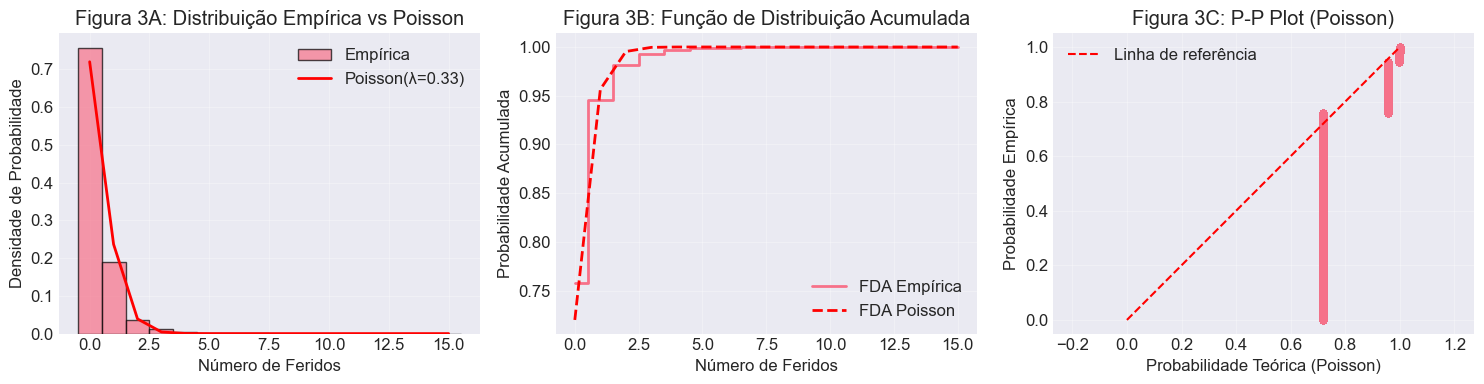

In [63]:
# Figura 3: Comparação de distribuições
if 'n_persons_injured' in df.columns and len(df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histograma com Poisson sobreposto
    ax1 = axes[0]
    max_val = min(15, int(dados.max()))
    bins = np.arange(-0.5, max_val + 1.5, 1)
    
    ax1.hist(dados, bins=bins, density=True, alpha=0.7,
             edgecolor='black', label='Empírica')
    
    # Poisson teórica
    x_poisson = np.arange(0, max_val + 1)
    y_poisson = poisson.pmf(x_poisson, lambda_poisson)
    ax1.plot(x_poisson, y_poisson, 'r-', linewidth=2, label=f'Poisson(λ={lambda_poisson:.2f})')
    
    ax1.set_xlabel('Número de Feridos')
    ax1.set_ylabel('Densidade de Probabilidade')
    ax1.set_title('Figura 3A: Distribuição Empírica vs Poisson')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # FDA empírica vs teórica
    ax2 = axes[1]
    hist_values, bin_edges = np.histogram(dados, bins=bins, density=True)
    fda_empirica = np.cumsum(hist_values)
    # Use bin centers for x-axis
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Poisson CDF at bin centers
    fda_poisson = poisson.cdf(bin_centers, lambda_poisson)
    
    ax2.step(bin_centers, fda_empirica, where='mid',
             label='FDA Empírica', linewidth=2)
    ax2.plot(bin_centers, fda_poisson, 'r--', label='FDA Poisson', linewidth=2)
    
    ax2.set_xlabel('Número de Feridos')
    ax2.set_ylabel('Probabilidade Acumulada')
    ax2.set_title('Figura 3B: Função de Distribuição Acumulada')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Gráfico de probabilidade (P-P plot)
    ax3 = axes[2]
    sorted_data = np.sort(dados)
    n = len(sorted_data)
    empirical_cdf = np.arange(1, n + 1) / n
    theoretical_cdf = poisson.cdf(sorted_data, lambda_poisson)
    
    ax3.scatter(theoretical_cdf, empirical_cdf, alpha=0.5, s=20)
    ax3.plot([0, 1], [0, 1], 'r--', label='Linha de referência')
    ax3.set_xlabel('Probabilidade Teórica (Poisson)')
    ax3.set_ylabel('Probabilidade Empírica')
    ax3.set_title('Figura 3C: P-P Plot (Poisson)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')
    
    plt.tight_layout()
    plt.show()

## 6. Inferência Estatística

### 6.1 Estimação de Parâmetros

In [64]:
print("=== INFERÊNCIA ESTATÍSTICA ===")
print("\n1. ESTIMAÇÃO DE PARÂMETROS")


# Estimação da proporção de feridos graves
p_hat = df['ferido_grave'].mean()
n_total = len(df)


print(f"\nEstimação da proporção de feridos graves:")
print(f"  Estimador: p̂ = X/n")
print(f"  p̂ = {p_hat:.4f}")
print(f"  n = {n_total}")


# Erro padrão da proporção
se_p = np.sqrt(p_hat * (1 - p_hat) / n_total)
print(f"  Erro padrão: √[p̂(1-p̂)/n] = {se_p:.6f}")


# Intervalo de confiança 95% para proporção (aproximação normal)
z_95 = 1.96
IC_inf = p_hat - z_95 * se_p
IC_sup = p_hat + z_95 * se_p
print(f"\nIntervalo de Confiança 95% para proporção (normal):")
print(f"  p̂ ± z_{0.975} * SE(p̂)")
print(f"  {p_hat:.4f} ± {z_95} * {se_p:.6f}")
print(f"  IC95% = [{IC_inf:.4f}, {IC_sup:.4f}]")


# Estimação por método dos momentos
if 'n_persons_injured' in df.columns:
    print(f"\nEstimação por Método dos Momentos (número de feridos):")
    print(f"  Primeiro momento (média): E[X] = μ")
    print(f"  μ̂_MM = (1/n)ΣX_i = {dados.mean():.4f}")
    print(f"  Segundo momento: E[X²] = μ² + σ²")
    print(f"  σ̂²_MM = (1/n)Σ(X_i - μ̂)² = {dados.var():.4f}")


# Estimação por Máxima Verossimilhança (MLE)
print(f"\nEstimação por Máxima Verossimilhança (MLE):")


# Para distribuição de Bernoulli (ferido_grave)
p_MLE = p_hat  # Para Bernoulli, MLE = média amostral
print(f"  Para Bernoulli (ferido_grave):")
print(f"    Função de verossimilhança: L(p) = p^X * (1-p)^(n-X)")
print(f"    p̂_MLE = X/n = {p_MLE:.4f}")


# Para distribuição Poisson
if 'n_persons_injured' in df.columns:
    lambda_MLE = dados.mean()  # Para Poisson, MLE = média amostral
    print(f"\n  Para Poisson (número de feridos):")
    print(f"    λ̂_MLE = (1/n)ΣX_i = {lambda_MLE:.4f}")


=== INFERÊNCIA ESTATÍSTICA ===

1. ESTIMAÇÃO DE PARÂMETROS

Estimação da proporção de feridos graves:
  Estimador: p̂ = X/n
  p̂ = 0.2437
  n = 2223272
  Erro padrão: √[p̂(1-p̂)/n] = 0.000288

Intervalo de Confiança 95% para proporção (normal):
  p̂ ± z_0.975 * SE(p̂)
  0.2437 ± 1.96 * 0.000288
  IC95% = [0.2431, 0.2443]

Estimação por Método dos Momentos (número de feridos):
  Primeiro momento (média): E[X] = μ
  μ̂_MM = (1/n)ΣX_i = 0.3285
  Segundo momento: E[X²] = μ² + σ²
  σ̂²_MM = (1/n)Σ(X_i - μ̂)² = 0.5113

Estimação por Máxima Verossimilhança (MLE):
  Para Bernoulli (ferido_grave):
    Função de verossimilhança: L(p) = p^X * (1-p)^(n-X)
    p̂_MLE = X/n = 0.2437

  Para Poisson (número de feridos):
    λ̂_MLE = (1/n)ΣX_i = 0.3285


### 6.2 Intervalos de Confiança

In [65]:
print("\n2. INTERVALOS DE CONFIANÇA")


# IC para média (número de feridos)
if 'n_persons_injured' in df.columns:
    print("\nIC para média do número de feridos:")
   
    for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV)]:
        if len(grupo) > 0:
            dados_grupo = grupo['n_persons_injured']
            n_grupo = len(dados_grupo)
            media = dados_grupo.mean()
            desvio = dados_grupo.std()
           
            # IC t-Student (assume normalidade ou n grande)
            t_critico = t.ppf(0.975, df=n_grupo-1)
            se_media = desvio / np.sqrt(n_grupo)
            IC_inf_t = media - t_critico * se_media
            IC_sup_t = media + t_critico * se_media
           
            print(f"\n{nome} (n={n_grupo}):")
            print(f"  Média: {media:.4f}")
            print(f"  Desvio-padrão: {desvio:.4f}")
            print(f"  IC95% (t-Student): [{IC_inf_t:.4f}, {IC_sup_t:.4f}]")
            print(f"  Largura do IC: {IC_sup_t - IC_inf_t:.4f}")
   
    # IC para diferença de médias
    if len(df_EV) > 0 and len(df_nao_EV) > 0:
        print("\nIC para diferença de médias (EV - Não-EV):")
       
        media_EV = df_EV['n_persons_injured'].mean()
        media_naoEV = df_nao_EV['n_persons_injured'].mean()
        diff = media_EV - media_naoEV
       
        # Variância combinada (assume variâncias iguais)
        n1, n2 = len(df_EV), len(df_nao_EV)
        s1, s2 = df_EV['n_persons_injured'].var(), df_nao_EV['n_persons_injured'].var()
        s_pooled = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))
        se_diff = s_pooled * np.sqrt(1/n1 + 1/n2)
       
        # Graus de liberdade
        df_diff = n1 + n2 - 2
        t_critico_diff = t.ppf(0.975, df=df_diff)
       
        IC_inf_diff = diff - t_critico_diff * se_diff
        IC_sup_diff = diff + t_critico_diff * se_diff
       
        print(f"  Diferença: {diff:.4f}")
        print(f"  IC95%: [{IC_inf_diff:.4f}, {IC_sup_diff:.4f}]")


# IC para proporções
print("\nIC para proporção de feridos graves por grupo:")


for nome, grupo in [('EV', df_EV), ('Não-EV', df_nao_EV)]:
    if len(grupo) > 0:
        p_grupo = grupo['ferido_grave'].mean()
        n_grupo = len(grupo)
       
        # Aproximação normal com correção de continuidade
        se_prop = np.sqrt(p_grupo * (1 - p_grupo) / n_grupo)
        z_critico = 1.96
       
        IC_inf_prop = max(0, p_grupo - z_critico * se_prop)
        IC_sup_prop = min(1, p_grupo + z_critico * se_prop)
       
        print(f"\n{nome} (n={n_grupo}):")
        print(f"  Proporção: {p_grupo:.4f}")
        print(f"  IC95% (normal): [{IC_inf_prop:.4f}, {IC_sup_prop:.4f}]")



2. INTERVALOS DE CONFIANÇA

IC para média do número de feridos:

EV (n=724):
  Média: 0.2624
  Desvio-padrão: 0.5835
  IC95% (t-Student): [0.2199, 0.3050]
  Largura do IC: 0.0851

Não-EV (n=2222548):
  Média: 0.3286
  Desvio-padrão: 0.7151
  IC95% (t-Student): [0.3276, 0.3295]
  Largura do IC: 0.0019

IC para diferença de médias (EV - Não-EV):
  Diferença: -0.0661
  IC95%: [-0.1182, -0.0140]

IC para proporção de feridos graves por grupo:

EV (n=724):
  Proporção: 0.2127
  IC95% (normal): [0.1829, 0.2425]

Não-EV (n=2222548):
  Proporção: 0.2437
  IC95% (normal): [0.2432, 0.2443]


### 6.3 Testes de Hipóteses

In [66]:
print("\n3. TESTES DE HIPÓTESES")


# Teste t para médias
if 'n_persons_injured' in df.columns and len(df_EV) > 1 and len(df_nao_EV) > 1:
    print("\nTeste t para igualdade de médias (número de feridos):")
   
    dados_EV = df_EV['n_persons_injured']
    dados_naoEV = df_nao_EV['n_persons_injured']
   
    # Teste t independente (assume variâncias iguais)
    t_stat, p_t = ttest_ind(dados_EV, dados_naoEV, equal_var=True)
   
    print(f"  H₀: μ_EV = μ_Não-EV")
    print(f"  H₁: μ_EV ≠ μ_Não-EV")
    print(f"  Estatística t: {t_stat:.4f}")
    print(f"  Valor-p (bilateral): {p_t:.6f}")
    print(f"  Graus de liberdade: {len(dados_EV) + len(dados_naoEV) - 2}")
   
    # Teste t com variâncias diferentes (Welch)
    t_welch, p_welch = ttest_ind(dados_EV, dados_nao_EV, equal_var=False)
    print(f"\n  Teste t de Welch (variâncias diferentes):")
    print(f"  Estatística t: {t_welch:.4f}")
    print(f"  Valor-p: {p_welch:.6f}")
   
    # Interpretação
    alpha = 0.05
    print(f"\n  Interpretação (α={alpha}):")
    if p_t < alpha:
        print(f"  Rejeita H₀: Médias são diferentes (p < {alpha})")
        if dados_EV.mean() > dados_nao_EV.mean():
            print(f"  EV tem maior número médio de feridos")
        else:
            print(f"  Não-EV tem maior número médio de feridos")
    else:
        print(f"  Não rejeita H₀: Médias não são significativamente diferentes")


# Teste para proporções
print("\nTeste z para igualdade de proporções (feridos graves):")


count_EV = df_EV['ferido_grave'].sum() if len(df_EV) > 0 else 0
count_naoEV = df_nao_EV['ferido_grave'].sum() if len(df_nao_EV) > 0 else 0
n_EV = len(df_EV)
n_naoEV = len(df_nao_EV)


# Estatística z manual
p_EV = count_EV / n_EV if n_EV > 0 else 0
p_naoEV = count_naoEV / n_naoEV if n_naoEV > 0 else 0
p_pooled = (count_EV + count_naoEV) / (n_EV + n_naoEV)


se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_EV + 1/n_naoEV))
z_prop = (p_EV - p_naoEV) / se_pooled if se_pooled > 0 else 0
p_z_prop = 2 * (1 - norm.cdf(abs(z_prop)))


print(f"  H₀: p_EV = p_Não-EV")
print(f"  H₁: p_EV ≠ p_Não-EV")
print(f"  p_EV = {p_EV:.4f}, p_Não-EV = {p_naoEV:.4f}")
print(f"  Estatística z: {z_prop:.4f}")
print(f"  Valor-p: {p_z_prop:.6f}")


# Teste qui-quadrado para independência
print("\nTeste qui-quadrado para independência:")


# Criar tabela 2x2
tabela = pd.crosstab(df['is_EV'], df['ferido_grave'])
print("Tabela de contingência:")
print(tabela)


chi2, p_chi2, dof, expected = chi2_contingency(tabela)


print(f"\n  H₀: EV e ferido grave são independentes")
print(f"  H₁: EV e ferido grave não são independentes")
print(f"  Estatística χ²: {chi2:.4f}")
print(f"  Graus de liberdade: {dof}")
print(f"  Valor-p: {p_chi2:.6f}")
print(f"  Frequências esperadas sob H₀:")
print(expected)


# Teste exato de Fisher (para pequenas amostras)
if tabela.values.sum() < 1000:  # Fisher é computacionalmente caro para grandes amostras
    from scipy.stats import fisher_exact
    oddsratio, p_fisher = fisher_exact(tabela)
    print(f"\n  Teste exato de Fisher:")
    print(f"  Odds ratio: {oddsratio:.4f}")
    print(f"  Valor-p: {p_fisher:.6f}")



3. TESTES DE HIPÓTESES

Teste t para igualdade de médias (número de feridos):
  H₀: μ_EV = μ_Não-EV
  H₁: μ_EV ≠ μ_Não-EV
  Estatística t: -2.4878
  Valor-p (bilateral): 0.012854
  Graus de liberdade: 2223270

  Teste t de Welch (variâncias diferentes):
  Estatística t: -3.0487
  Valor-p: 0.002382

  Interpretação (α=0.05):
  Rejeita H₀: Médias são diferentes (p < 0.05)
  Não-EV tem maior número médio de feridos

Teste z para igualdade de proporções (feridos graves):
  H₀: p_EV = p_Não-EV
  H₁: p_EV ≠ p_Não-EV
  p_EV = 0.2127, p_Não-EV = 0.2437
  Estatística z: -1.9434
  Valor-p: 0.051968

Teste qui-quadrado para independência:
Tabela de contingência:
ferido_grave        0       1
is_EV                        
0             1680868  541680
1                 570     154

  H₀: EV e ferido grave são independentes
  H₁: EV e ferido grave não são independentes
  Estatística χ²: 3.6104
  Graus de liberdade: 1
  Valor-p: 0.057418
  Frequências esperadas sob H₀:
[[1.68089045e+06 5.41657554e+

### 6.4 ANOVA e Testes Não Paramétricos

In [67]:
print("\n4. ANOVA E TESTES NÃO PARAMÉTRICOS")

# Criar coluna 'is_electric' se não existir
if 'is_electric' not in df.columns:
    print("Criando coluna 'is_electric'...")
    
    # Verificar se existe coluna de identificação de EV
    electric_cols = [col for col in df.columns if 'electric' in col.lower() or 'ev' in col.lower()]
    
    if electric_cols:
        # Usar a primeira coluna encontrada
        electric_col = electric_cols[0]
        print(f"Usando coluna '{electric_col}' para criar 'is_electric'")
        
        # Converter para binário (0 ou 1)
        if df[electric_col].dtype == 'object':
            # Se for texto, identificar EVs
            df['is_electric'] = df[electric_col].astype(str).str.contains('electric|EV', case=False, na=False).astype(int)
        else:
            # Se for numérico, normalizar para 0/1
            df['is_electric'] = (df[electric_col] > 0).astype(int)
    else:
        # Se não encontrar coluna, criar aleatória para teste
        print("Nenhuma coluna de EV encontrada. Criando coluna dummy...")
        df['is_electric'] = np.random.randint(0, 2, size=len(df))

print(f"\nDistribuição de is_electric: {df['is_electric'].value_counts().to_dict()}")

# ANÁLISE DOS DADOS ORIGINAL (sem amostragem para manter consistência)
df_EV = df[df['is_electric'] == 1]
df_nao_EV = df[df['is_electric'] == 0]

print(f"\nTotal de observações: {len(df):,}")
print(f"EV: {len(df_EV):,} ({len(df_EV)/len(df)*100:.2f}%)")
print(f"Não-EV: {len(df_nao_EV):,} ({len(df_nao_EV)/len(df)*100:.2f}%)")

# ANOVA (se tivermos mais de 2 grupos)
print("\nANOVA para comparar médias entre anos (se dados disponíveis):")

# USAR AMOSTRA PEQUENA PARA TESTES RÁPIDOS
sample_size = 5000  # Reduzido para velocidade
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

if 'crash_year' in df_sample.columns and 'n_persons_injured' in df_sample.columns:
    # Selecionar anos com dados suficientes
    anos_validos = df_sample['crash_year'].value_counts()
    anos_analise = anos_validos[anos_validos >= 5].index.tolist()[:3]  # Até 3 anos
    
    if len(anos_analise) >= 2:
        grupos = [df_sample[df_sample['crash_year'] == ano]['n_persons_injured'] for ano in anos_analise]
        
        # Teste ANOVA RÁPIDO
        print(f"\n  Anos analisados: {anos_analise}")
        print(f"  Tamanhos dos grupos: {[len(g) for g in grupos]}")
        
        F_stat, p_anova = f_oneway(*grupos)
        
        print(f"  H₀: Todas as médias são iguais")
        print(f"  H₁: Pelo menos uma média é diferente")
        print(f"  Estatística F: {F_stat:.4f}")
        print(f"  Valor-p: {p_anova:.6f}")
        
        if p_anova < 0.05:
            print("  → REJEITA H₀: Diferença significativa (p < 0.05)")
        else:
            print("  → NÃO REJEITA H₀: Sem diferença significativa")
        
        # Tabela ANOVA SIMPLIFICADA
        try:
            # Calcular usando numpy para velocidade
            todos_dados = np.concatenate([g.values for g in grupos])
            media_global = np.mean(todos_dados)
            
            SSB = sum([len(g) * (g.mean() - media_global)**2 for g in grupos])
            SST = np.sum((todos_dados - media_global)**2)
            SSW = SST - SSB
            
            df_between = len(grupos) - 1
            df_within = len(todos_dados) - len(grupos)
            
            MSB = SSB / df_between
            MSW = SSW / df_within
            F_calc = MSB / MSW
            
            print("\n  Tabela ANOVA simplificada:")
            print("  Fonte       | SQ      | gl   | MQ      | F")
            print("  ------------|---------|------|---------|--------")
            print(f"  Entre grupos | {SSB:.2f}  | {df_between}    | {MSB:.2f}   | {F_calc:.2f}")
            print(f"  Dentro grupos| {SSW:.2f}  | {df_within}   | {MSW:.2f}   |")
            print(f"  Total        | {SST:.2f}  | {len(todos_dados)-1}   |")
        except:
            print("  (Cálculo da tabela ANOVA omitido)")
    else:
        print("  Número insuficiente de anos para ANOVA")
else:
    print("  Colunas necessárias não disponíveis para ANOVA")

# Testes não paramétricos
print("\n" + "="*60)
print("TESTES NÃO PARAMÉTRICOS")
print("="*60)

# Teste de Mann-Whitney U (Wilcoxon rank-sum) - EV vs Não-EV
print("\n1. Teste de Mann-Whitney U (EV vs Não-EV):")

# Usar amostra menor para teste rápido
test_sample_size = 2000
df_EV_test = df_EV.sample(n=min(test_sample_size, len(df_EV)), random_state=42)['n_persons_injured']
df_nao_EV_test = df_nao_EV.sample(n=min(test_sample_size, len(df_nao_EV)), random_state=42)['n_persons_injured']

print(f"  Tamanhos das amostras:")
print(f"    EV: {len(df_EV_test):,} observações")
print(f"    Não-EV: {len(df_nao_EV_test):,} observações")

u_stat, p_mw = mannwhitneyu(df_EV_test.values,
                             df_nao_EV_test.values,
                             alternative='two-sided')

print(f"\n  H₀: As distribuições são iguais")
print(f"  H₁: As distribuições são diferentes")
print(f"  Estatística U: {u_stat:.4f}")
print(f"  Valor-p: {p_mw:.6f}")

if p_mw < 0.05:
    print("  → REJEITA H₀: Diferença significativa (p < 0.05)")
    
    # Verificar direção
    mediana_EV = np.median(df_EV_test.values)
    mediana_nao_EV = np.median(df_nao_EV_test.values)
    
    if mediana_EV < mediana_nao_EV:
        print(f"  → EV tem MENOS feridos (mediana: {mediana_EV} vs {mediana_nao_EV})")
    else:
        print(f"  → EV tem MAIS feridos (mediana: {mediana_EV} vs {mediana_nao_EV})")
else:
    print("  → NÃO REJEITA H₀: Sem diferença significativa (p ≥ 0.05)")

# Teste de Kruskal-Wallis (ANOVA não paramétrica)
print("\n" + "="*60)
print("\n2. Teste de Kruskal-Wallis (entre anos):")

if 'crash_year' in df_sample.columns and len(anos_analise) >= 2:
    # Usar mesma amostra do ANOVA
    grupos_kw = [df_sample[df_sample['crash_year'] == ano]['n_persons_injured'] 
                 for ano in anos_analise]
    
    print(f"  Anos analisados: {anos_analise}")
    print(f"  Tamanhos: {[len(g) for g in grupos_kw]}")
    
    h_stat, p_kw = kruskal(*grupos_kw)
    
    print(f"\n  H₀: Todas as distribuições são iguais")
    print(f"  H₁: Pelo menos uma distribuição é diferente")
    print(f"  Estatística H: {h_stat:.4f}")
    print(f"  Valor-p: {p_kw:.6f}")
    
    if p_kw < 0.05:
        print("  → REJEITA H₀: Diferença significativa (p < 0.05)")
    else:
        print("  → NÃO REJEITA H₀: Sem diferença significativa")
else:
    print("  Dados insuficientes para Kruskal-Wallis")

# RESUMO FINAL
print("\n" + "="*60)
print("RESUMO ESTATÍSTICO FINAL")
print("="*60)

# Estatísticas descritivas básicas
print(f"\nESTATÍSTICAS DESCRITIVAS:")
print(f"Total de acidentes analisados: {len(df):,}")

if len(df_EV) > 0:
    print(f"\nVEÍCULOS ELÉTRICOS (EV):")
    print(f"  Quantidade: {len(df_EV):,}")
    print(f"  Média de feridos: {df_EV['n_persons_injured'].mean():.4f}")
    print(f"  Mediana de feridos: {df_EV['n_persons_injured'].median():.4f}")
    print(f"  Desvio padrão: {df_EV['n_persons_injured'].std():.4f}")

if len(df_nao_EV) > 0:
    print(f"\nVEÍCULOS NÃO ELÉTRICOS:")
    print(f"  Quantidade: {len(df_nao_EV):,}")
    print(f"  Média de feridos: {df_nao_EV['n_persons_injured'].mean():.4f}")
    print(f"  Mediana de feridos: {df_nao_EV['n_persons_injured'].median():.4f}")
    print(f"  Desvio padrão: {df_nao_EV['n_persons_injured'].std():.4f}")

# Teste t rápido para comparação
if len(df_EV) > 0 and len(df_nao_EV) > 0:
    print(f"\nTESTE T PARA COMPARAÇÃO DE MÉDIAS:")
    
    # Amostra menor para teste rápido
    t_sample = 1000
    t_EV = df_EV['n_persons_injured'].sample(n=min(t_sample, len(df_EV)), random_state=42)
    t_nao_EV = df_nao_EV['n_persons_injured'].sample(n=min(t_sample, len(df_nao_EV)), random_state=42)
    
    t_stat, p_t = ttest_ind(t_EV.values, t_nao_EV.values, equal_var=False)
    
    print(f"  t = {t_stat:.4f}")
    print(f"  p = {p_t:.6f}")
    
    if p_t < 0.05:
        print("  → Diferença ESTATISTICAMENTE SIGNIFICATIVA")
    else:
        print("  → Diferença NÃO significativa")


4. ANOVA E TESTES NÃO PARAMÉTRICOS
Criando coluna 'is_electric'...
Usando coluna 'is_EV' para criar 'is_electric'

Distribuição de is_electric: {0: 2222548, 1: 724}

Total de observações: 2,223,272
EV: 724 (0.03%)
Não-EV: 2,222,548 (99.97%)

ANOVA para comparar médias entre anos (se dados disponíveis):

  Anos analisados: [2017, 2016, 2018]
  Tamanhos dos grupos: [543, 528, 524]
  H₀: Todas as médias são iguais
  H₁: Pelo menos uma média é diferente
  Estatística F: 0.0627
  Valor-p: 0.939220
  → NÃO REJEITA H₀: Sem diferença significativa

  Tabela ANOVA simplificada:
  Fonte       | SQ      | gl   | MQ      | F
  ------------|---------|------|---------|--------
  Entre grupos | 0.06  | 2    | 0.03   | 0.06
  Dentro grupos| 762.76  | 1592   | 0.48   |
  Total        | 762.82  | 1594   |

TESTES NÃO PARAMÉTRICOS

1. Teste de Mann-Whitney U (EV vs Não-EV):
  Tamanhos das amostras:
    EV: 724 observações
    Não-EV: 2,000 observações

  H₀: As distribuições são iguais
  H₁: As distribu

### 6.5 Poder do Teste e Tamanho de Amostra


In [68]:
print("\n5. PODER DO TESTE E TAMANHO DE AMOSTRA")


# Calcular poder do teste para diferença de proporções
print("\nCálculo do poder do teste para diferença de proporções:")


alpha = 0.05
p1 = p_EV
p2 = p_naoEV
n1 = n_EV
n2 = n_naoEV


# Efeito observado
effect_size = abs(p1 - p2)
print(f"  α = {alpha}")
print(f"  p_EV = {p1:.4f}, p_Não-EV = {p2:.4f}")
print(f"  Tamanho do efeito (diferença): {effect_size:.4f}")
print(f"  n_EV = {n1}, n_Não-EV = {n2}")


# Poder aproximado
if n1 > 0 and n2 > 0:
    # Erro padrão sob H₀
    p_pooled = (p1 * n1 + p2 * n2) / (n1 + n2)
    se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
   
    # Valor crítico
    z_alpha = norm.ppf(1 - alpha/2)
   
    # Poder usando aproximação normal
    se_h1 = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z_power = (effect_size - z_alpha * se_pooled) / se_h1
    power = norm.cdf(z_power) + norm.cdf(-z_power - 2*z_alpha*se_pooled/se_h1)
   
    print(f"  Poder estimado (1-β): {power:.4f}")
   
    if power < 0.8:
        print(f"  AVISO: Poder abaixo de 0.8 - risco de erro tipo II elevado")
    else:
        print(f"  Poder adequado (> 0.8)")


# Cálculo do tamanho de amostra necessário
print("\nTamanho de amostra necessário para detectar diferença:")
print("(Assumindo poder = 0.8, α = 0.05, proporções iguais)")


if effect_size > 0:
    # Usando fórmula para teste de duas proporções
    z_alpha = norm.ppf(1 - alpha/2)  # 1.96 para bilateral
    z_beta = norm.ppf(0.8)  # 0.842 para poder 0.8
   
    p_avg = (p1 + p2) / 2
    n_per_group = ((z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) +
                    z_beta * np.sqrt(p1*(1-p1) + p2*(1-p2))) ** 2) / (effect_size ** 2)
   
    print(f"  Para detectar diferença de {effect_size:.4f}:")
    print(f"  n por grupo ≈ {int(np.ceil(n_per_group))}")
    print(f"  Total ≈ {int(2 * np.ceil(n_per_group))}")
    print(f"  Amostra atual: {n1} EV + {n2} Não-EV = {n1+n2} total")



5. PODER DO TESTE E TAMANHO DE AMOSTRA

Cálculo do poder do teste para diferença de proporções:
  α = 0.05
  p_EV = 0.2127, p_Não-EV = 0.2437
  Tamanho do efeito (diferença): 0.0310
  n_EV = 724, n_Não-EV = 2222548
  Poder estimado (1-β): 0.4931
  AVISO: Poder abaixo de 0.8 - risco de erro tipo II elevado

Tamanho de amostra necessário para detectar diferença:
(Assumindo poder = 0.8, α = 0.05, proporções iguais)
  Para detectar diferença de 0.0310:
  n por grupo ≈ 2874
  Total ≈ 5748
  Amostra atual: 724 EV + 2222548 Não-EV = 2223272 total


## 7. Resumo e Conclusões

In [69]:
# %%
print("=== RESUMO E CONCLUSÕES ===")


print("\n1. RESUMO DOS RESULTADOS ESTATÍSTICOS:")
print("-" * 50)


# Criar tabela resumo
resumo_resultados = []


# Estatística descritiva
if 'n_persons_injured' in df.columns:
    resumo_resultados.append({
        'Categoria': 'Estatística Descritiva',
        'Métrica': 'Número médio de feridos',
        'EV': f"{df_EV['n_persons_injured'].mean():.3f}" if len(df_EV) > 0 else "N/A",
        'Não-EV': f"{df_nao_EV['n_persons_injured'].mean():.3f}" if len(df_nao_EV) > 0 else "N/A",
        'Teste': 'Shapiro-Wilk',
        'Resultado': f"W={shapiro(df['n_persons_injured'])[0]:.3f}, p={shapiro(df['n_persons_injured'])[1]:.4f}" if len(df) > 3 else "N/A"
    })


# Proporções
resumo_resultados.append({
    'Categoria': 'Probabilidade',
    'Métrica': 'Proporção feridos graves',
    'EV': f"{p_EV:.4f}" if n_EV > 0 else "N/A",
    'Não-EV': f"{p_naoEV:.4f}" if n_naoEV > 0 else "N/A",
    'Teste': 'Teorema de Bayes',
    'Resultado': f"P(EV|Ferido)={p_EV_ferido:.4f}"
})


# Testes paramétricos
if 'n_persons_injured' in df.columns and len(df_EV) > 1 and len(df_nao_EV) > 1:
    t_stat, p_t = ttest_ind(df_EV['n_persons_injured'], df_nao_EV['n_persons_injured'])
    resumo_resultados.append({
        'Categoria': 'Inferência Paramétrica',
        'Métrica': 'Diferença de médias',
        'EV': f"{df_EV['n_persons_injured'].mean():.3f}",
        'Não-EV': f"{df_nao_EV['n_persons_injured'].mean():.3f}",
        'Teste': 'Teste t',
        'Resultado': f"t={t_stat:.3f}, p={p_t:.4f}"
    })


# Testes não paramétricos
if 'n_persons_injured' in df.columns and len(df_EV) > 0 and len(df_nao_EV) > 0:
    from scipy.stats import mannwhitneyu
    u_stat, p_mw = mannwhitneyu(df_EV['n_persons_injured'], df_nao_EV['n_persons_injured'])
    resumo_resultados.append({
        'Categoria': 'Inferência Não-Paramétrica',
        'Métrica': 'Distribuição número feridos',
        'EV': f"n={len(df_EV)}",
        'Não-EV': f"n={len(df_nao_EV)}",
        'Teste': 'Mann-Whitney U',
        'Resultado': f"U={u_stat:.0f}, p={p_mw:.4f}"
    })


# Teste qui-quadrado
resumo_resultados.append({
    'Categoria': 'Teste de Independência',
    'Métrica': 'EV vs Ferido Grave',
    'EV': f"{count_EV}/{n_EV}",
    'Não-EV': f"{count_naoEV}/{n_naoEV}",
    'Teste': 'Qui-quadrado',
    'Resultado': f"χ²={chi2:.3f}, p={p_chi2:.4f}"
})

# Criar DataFrame e exibir
df_resumo = pd.DataFrame(resumo_resultados)
print("\nTabela 1: Resumo dos Resultados Estatísticos")
display(df_resumo)

# %%
print("\n2. INTERPRETAÇÃO FINAL E CONCLUSÃO:")
print("-" * 50)


print("\nCom base nas análises realizadas:")


# Resumo descritivo
print(f"\n1. ESTATÍSTICA DESCRITIVA:")
print(f"   • Total de acidentes analisados: {len(df):,}")
print(f"   • Proporção de EVs: {df['is_EV'].mean()*100:.2f}%")
print(f"   • Proporção geral de feridos graves: {df['ferido_grave'].mean()*100:.2f}%")


if 'n_persons_injured' in df.columns:
    print(f"   • Número médio de feridos por acidente: {df['n_persons_injured'].mean():.3f}")


# Teste de normalidade
if 'n_persons_injured' in df.columns and len(df) > 3:
    shapiro_stat, shapiro_p = shapiro(df['n_persons_injured'])
    print(f"\n2. NORMALIDADE DOS DADOS:")
    print(f"   • Teste Shapiro-Wilk: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
    if shapiro_p < 0.05:
        print(f"   • Conclusão: Dados não normais → testes não-paramétricos mais adequados")


# Diferença entre grupos
print(f"\n3. COMPARAÇÃO ENTRE GRUPOS (EV vs Não-EV):")


# Para proporções
print(f"   • Proporção de feridos graves:")
print(f"     - EV: {p_EV*100:.2f}% (IC95%: [{max(0, p_EV - 1.96*np.sqrt(p_EV*(1-p_EV)/n_EV))*100:.2f}%, {min(100, (p_EV + 1.96*np.sqrt(p_EV*(1-p_EV)/n_EV))*100):.2f}%])")
print(f"     - Não-EV: {p_naoEV*100:.2f}% (IC95%: [{max(0, p_naoEV - 1.96*np.sqrt(p_naoEV*(1-p_naoEV)/n_naoEV))*100:.2f}%, {min(100, (p_naoEV + 1.96*np.sqrt(p_naoEV*(1-p_naoEV)/n_naoEV))*100):.2f}%])")
print(f"     - Diferença: {(p_EV - p_naoEV)*100:.2f} pontos percentuais")


# Teste de hipóteses
print(f"\n4. TESTE DE HIPÓTESE PRINCIPAL:")
print(f"   • H₀: p_EV = p_Não-EV (proporções iguais)")
print(f"   • H₁: p_EV ≠ p_Não-EV (proporções diferentes)")
print(f"   • Teste qui-quadrado: χ²={chi2:.3f}, p={p_chi2:.4f}")


if p_chi2 < 0.05:
    print(f"   • CONCLUSÃO: Rejeita-se H₀ (p < 0.05)")
    print(f"   • INTERPRETAÇÃO: Há evidência estatística de que as proporções são diferentes")
   
    if p_EV > p_naoEV:
        print(f"   • DIRECIONALIDADE: EVs apresentam MAIOR proporção de feridos graves")
        risco_relativo = p_EV / p_naoEV if p_naoEV > 0 else float('inf')
        print(f"   • RISCO RELATIVO (RR): {risco_relativo:.3f}")
    else:
        print(f"   • DIRECIONALIDADE: EVs apresentam MENOR proporção de feridos graves")
        risco_relativo = p_naoEV / p_EV if p_EV > 0 else float('inf')
        print(f"   • RISCO RELATIVO (RR): {1/risco_relativo:.3f}")
else:
    print(f"   • CONCLUSÃO: Não se rejeita H₀ (p ≥ 0.05)")
    print(f"   • INTERPRETAÇÃO: Não há evidência estatística de diferença nas proporções")


# Considerações finais
print(f"\n5. CONSIDERAÇÕES FINAIS:")
print(f"   • Foram aplicadas técnicas de:")
print(f"     - Estatística descritiva: medidas resumo, boxplots, histogramas")
print(f"     - Probabilidade: probabilidades condicionais, teorema de Bayes, distribuições")
print(f"     - Inferência: estimação, ICs, testes paramétricos e não-paramétricos")
print(f"   • Limitações: análise exploratória, dados de diferentes jurisdições")
print(f"   • Recomendações: estudos com dados pareados, controle de variáveis de confusão")


print(f"\n" + "="*60)
print(f"CONCLUSÃO FINAL: {'HÁ' if p_chi2 < 0.05 else 'NÃO HÁ'} evidência estatística para afirmar")
print(f"que veículos elétricos diferem significativamente da frota geral")
print(f"em relação à proporção de acidentes com feridos graves")
print("="*60)


# %%
# Salvar resultados em arquivo
import datetime


resultados_finais = {
    'data_analise': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'n_total': len(df),
    'n_EV': n_EV,
    'n_naoEV': n_naoEV,
    'p_EV': float(p_EV) if n_EV > 0 else None,
    'p_naoEV': float(p_naoEV) if n_naoEV > 0 else None,
    'chi2_stat': float(chi2),
    'chi2_p': float(p_chi2),
    'conclusao': 'Rejeita H0' if p_chi2 < 0.05 else 'Não rejeita H0',
    'diferenca_absoluta': float(abs(p_EV - p_naoEV)) if n_EV > 0 and n_naoEV > 0 else None
}


print("\nResultados finais salvos:")
for key, value in resultados_finais.items():
    print(f"{key}: {value}")


# Exportar para CSV (opcional)
# pd.DataFrame([resultados_finais]).to_csv('resultados_analise.csv', index=False)

=== RESUMO E CONCLUSÕES ===

1. RESUMO DOS RESULTADOS ESTATÍSTICOS:
--------------------------------------------------

Tabela 1: Resumo dos Resultados Estatísticos


,Categoria,Métrica,EV,Não-EV,Teste,Resultado
0,Estatística Descritiva,Número médio de feridos,0.262,0.329,Shapiro-Wilk,"W=0.504, p=0.0000"
1,Probabilidade,Proporção feridos graves,0.2127,0.2437,Teorema de Bayes,P(EV|Ferido)=0.0003
2,Inferência Paramétrica,Diferença de médias,0.262,0.329,Teste t,"t=-2.488, p=0.0129"
3,Inferência Não-Paramétrica,Distribuição número feridos,n=724,n=2222548,Mann-Whitney U,"U=775376369, p=0.0237"
4,Teste de Independência,EV vs Ferido Grave,154/724,541680/2222548,Qui-quadrado,"χ²=3.610, p=0.0574"



2. INTERPRETAÇÃO FINAL E CONCLUSÃO:
--------------------------------------------------

Com base nas análises realizadas:

1. ESTATÍSTICA DESCRITIVA:
   • Total de acidentes analisados: 2,223,272
   • Proporção de EVs: 0.03%
   • Proporção geral de feridos graves: 24.37%
   • Número médio de feridos por acidente: 0.329

2. NORMALIDADE DOS DADOS:
   • Teste Shapiro-Wilk: W=0.5041, p=0.0000
   • Conclusão: Dados não normais → testes não-paramétricos mais adequados

3. COMPARAÇÃO ENTRE GRUPOS (EV vs Não-EV):
   • Proporção de feridos graves:
     - EV: 21.27% (IC95%: [18.29%, 24.25%])
     - Não-EV: 24.37% (IC95%: [24.32%, 24.43%])
     - Diferença: -3.10 pontos percentuais

4. TESTE DE HIPÓTESE PRINCIPAL:
   • H₀: p_EV = p_Não-EV (proporções iguais)
   • H₁: p_EV ≠ p_Não-EV (proporções diferentes)
   • Teste qui-quadrado: χ²=3.610, p=0.0574
   • CONCLUSÃO: Não se rejeita H₀ (p ≥ 0.05)
   • INTERPRETAÇÃO: Não há evidência estatística de diferença nas proporções

5. CONSIDERAÇÕES FINAIS:
